12 4
['F1-0'] ['A1-1']
torch.Size([17280, 5000]) torch.Size([17280, 3])
tensor([1183, 8019, 8078])
torch.Size([17280, 5000]) torch.Size([17280, 3])
tensor([ 943, 7976, 8361])


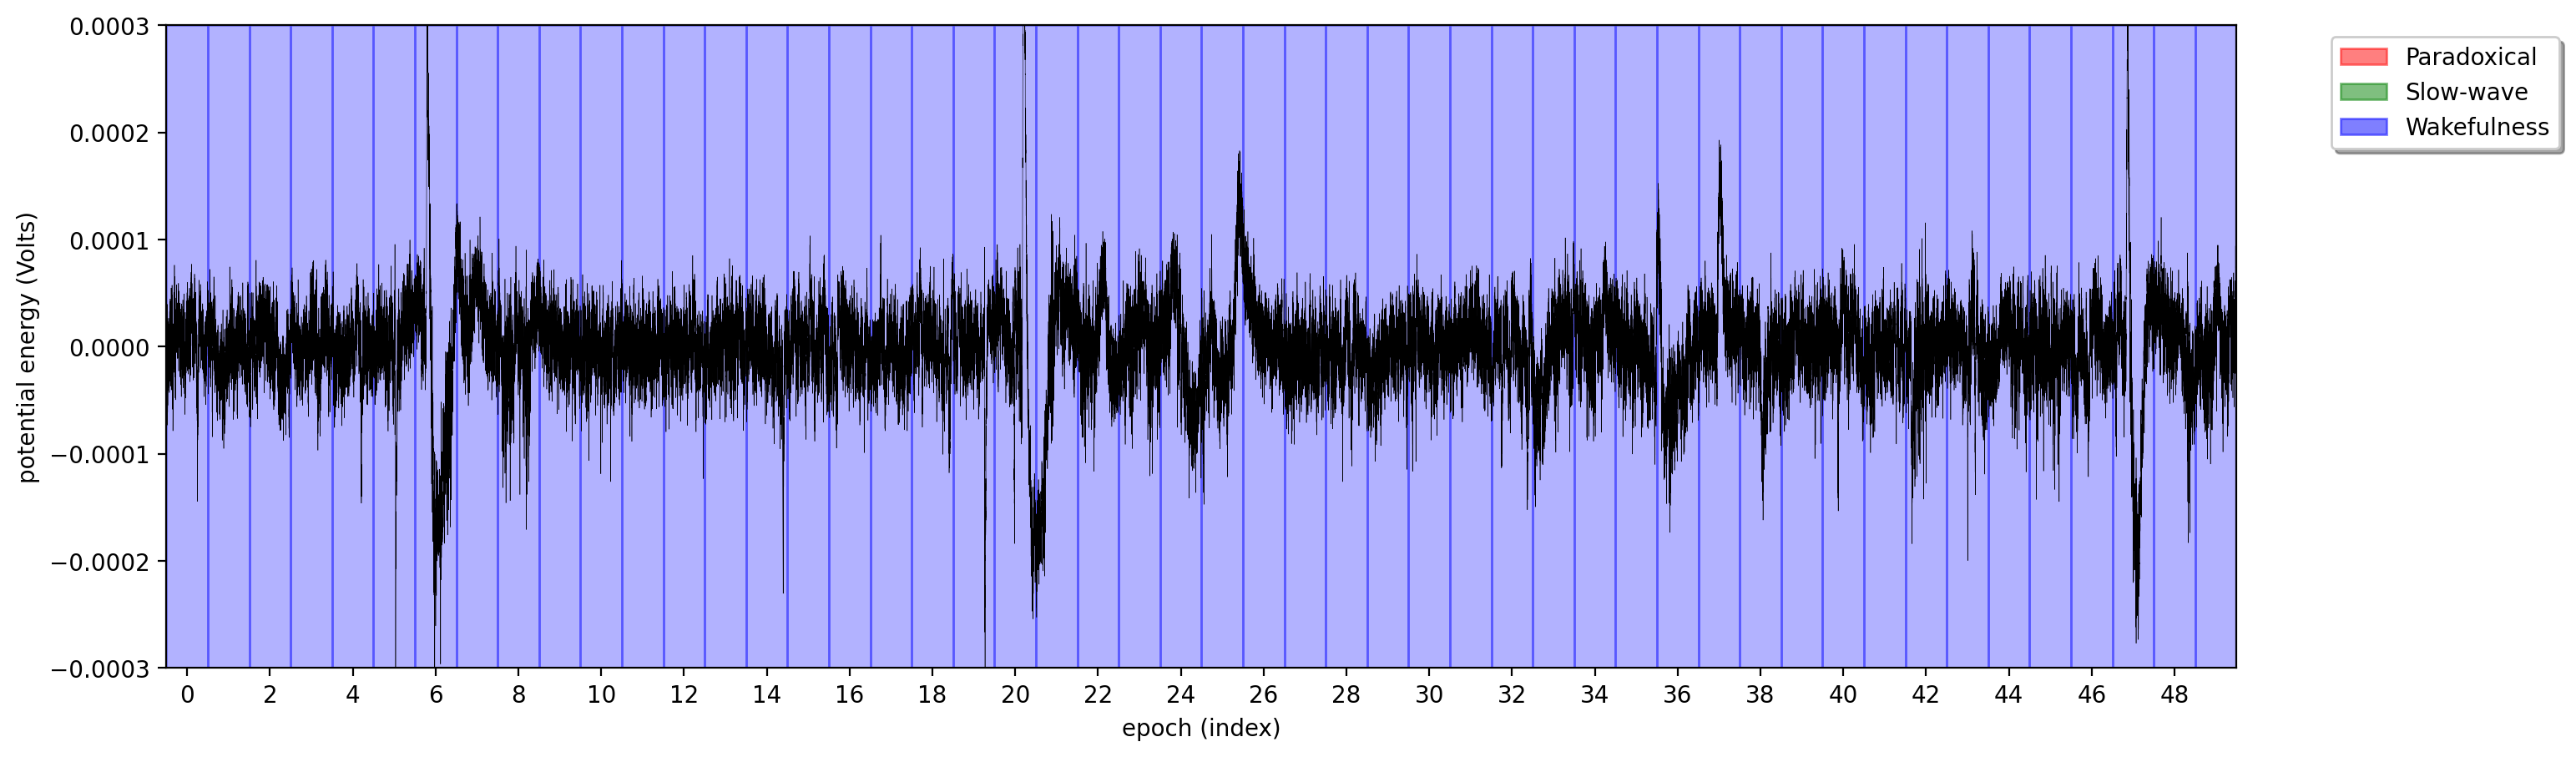

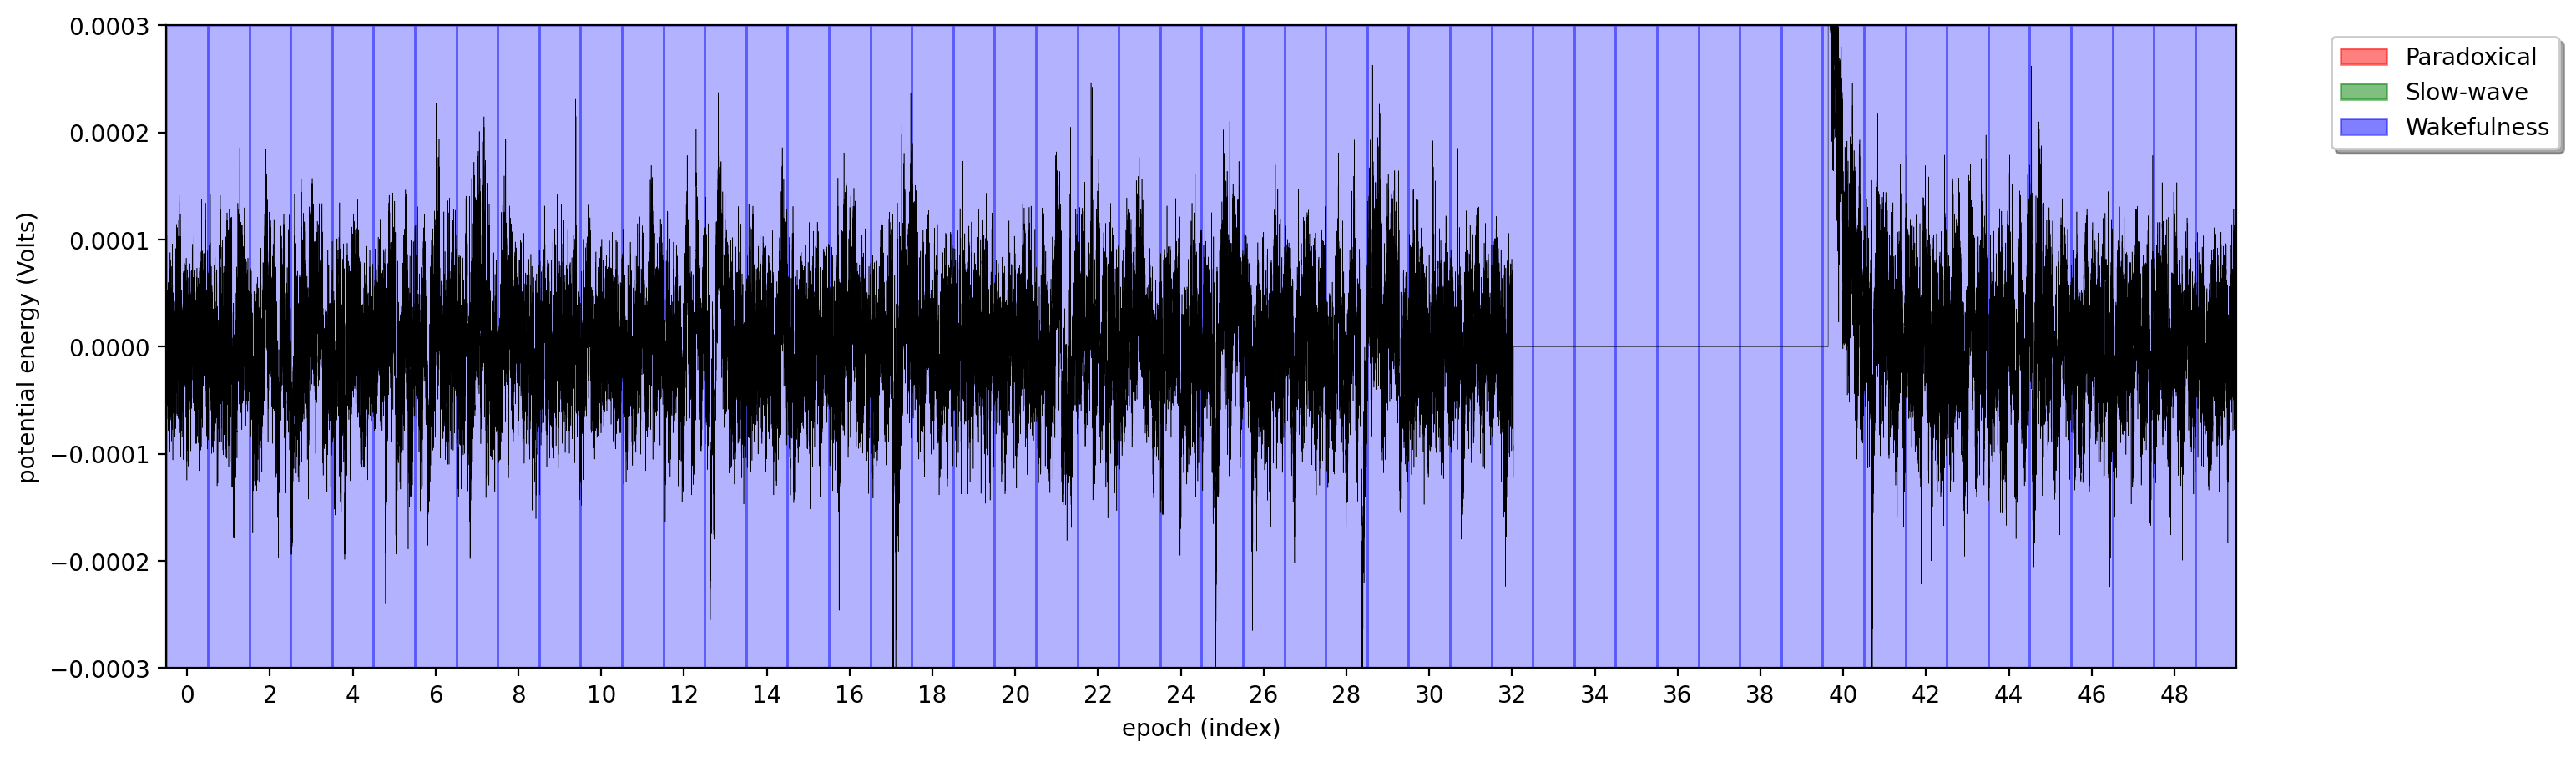

In [1]:
%load_ext autoreload
%autoreload 2
from lib.ekyn import *
from sklearn.model_selection import train_test_split
from torch import bincount
from lib.utils import plot_eeg_and_labels
from lib.models import MLP
from tqdm import tqdm
from torch import optim
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader,Dataset
import torch
import numpy as np
import random
from lib.utils import evaluate
from sklearn.metrics import ConfusionMatrixDisplay,classification_report
from lib.env import DEVICE
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
from torch.nn.functional import relu
class Windowset(Dataset):
    def __init__(self,X,y,windowsize):
        self.windowsize = windowsize
        self.X = cat([zeros(windowsize // 2,5000),X,zeros(windowsize // 2,5000)])
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (self.X[idx:idx+self.windowsize],self.y[idx])
windowsize = 3
idx = get_ekyn_ids()
train_idx,test_idx = train_test_split(idx,test_size=.25,random_state=0)
print(len(train_idx),len(test_idx))
train_idx = train_idx[:1]
test_idx = test_idx[:1]
print(train_idx,test_idx)
X,y = load_eeg_label_pairs(ids=train_idx)
print(X.shape,y.shape)
print(bincount(y.argmax(axis=1)))
plot_eeg_and_labels(X,y.argmax(axis=1),start=0,duration=50)
trainloader = DataLoader(Windowset(X,y,windowsize),batch_size=512,shuffle=True)
X,y = load_eeg_label_pairs(ids=test_idx)
print(X.shape,y.shape)
print(bincount(y.argmax(axis=1)))
plot_eeg_and_labels(X,y.argmax(axis=1),start=0,duration=50)
devloader = DataLoader(Windowset(X,y,windowsize),batch_size=512,shuffle=True)

In [47]:
class MyLSTM(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.lstm = nn.LSTM(input_size=5000,hidden_size=32,batch_first=True)
        self.classifier = nn.Linear(in_features=32,out_features=3)
    def forward(self,x):
        _,(h,_) = self.lstm(x)
        x = self.classifier(h.squeeze())
        return x
model = MyLSTM()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=3e-4)
params = sum([p.flatten().size()[0] for p in list(model.parameters())])
print("Params: ",params)
lossi = []
trainlossi = []
devlossi = []

Params:  644451


In [49]:
Xi,yi = next(iter(trainloader))
print(Xi.shape,yi.shape)

torch.Size([512, 3, 5000]) torch.Size([512, 3])


In [50]:
for epoch in tqdm(range(1000)):
    logits = model(Xi)
    loss = criterion(logits,yi)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lossi.append(loss.item())
loss

100%|██████████| 1000/1000 [00:11<00:00, 85.65it/s]


tensor(0.8768, grad_fn=<DivBackward1>)

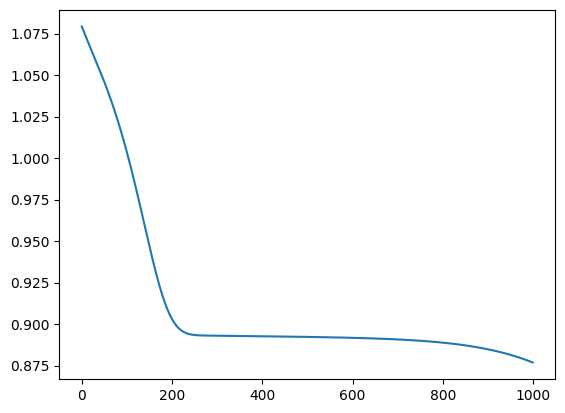

In [51]:
plt.plot(lossi)

In [ ]:
model.train()
model.to(DEVICE)
for epoch in tqdm(range(10)):
    for Xi,yi in trainloader:
        Xi,yi = Xi.to(DEVICE),yi.to(DEVICE)
        logits = model(Xi)
        loss = criterion(logits,yi)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())
    if epoch % 1 == 0:
        plt.plot(torch.tensor(lossi[:len(lossi) - len(lossi)%10]).view(-1,10).mean(axis=1))
        plt.savefig('loss.jpg')
        plt.close()

        loss,_,_,_,_ = evaluate(dataloader=trainloader,model=model,criterion=criterion,DEVICE=DEVICE)
        trainlossi.append(loss)
        loss,_,_,_,_ = evaluate(dataloader=devloader,model=model,criterion=criterion,DEVICE=DEVICE)
        devlossi.append(loss)
        print(loss)

        plt.plot(trainlossi)
        plt.plot(devlossi)
        plt.savefig('dev.jpg')
        plt.close()

In [ ]:
loss,report,y_true,y_pred,y_logits = evaluate(dataloader=devloader,model=model,criterion=criterion,DEVICE=DEVICE)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true')
print(classification_report(y_true,y_pred))
print(loss)
# 0 : 75 f1
# 1 : 75 f1
# 4 : 81
# 6 : 82


In [ ]:
import matplotlib.patches as patches
start = 600
duration = 400
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(16,5),dpi=200)

ax[1].plot(X[start:start+duration].flatten(),'black',linewidth=.2)
colors = ['red','green','blue']
epochs = []
for i in range(duration):
    stage = int(y.argmax(axis=1)[start+i])
    ax[1].fill_between([i*5000, (i+1)*5000], y1=-.0003, y2=.0003, color=colors[stage], alpha=0.3)
    epochs.append(i*5000+2500)

red_patch = patches.Patch(color='red', alpha=0.5, label='Paradoxical')
green_patch = patches.Patch(color='green', alpha=0.5, label='Slow-wave')
blue_patch = patches.Patch(color='blue', alpha=0.5, label='Wakefulness')
ax[1].set_ylim([-.0003,.0003])
ax[1].margins(0,0)
plt.legend(handles=[red_patch, green_patch,blue_patch],loc='upper left', bbox_to_anchor=(1.04, 1),
        fancybox=True, shadow=True, ncol=1)
plt.xlabel('epoch (index)')
ax[1].set_ylabel('potential energy (Volts)')
ax[1].set_xticks(epochs[::int(duration/20)],range(duration)[::int(duration/20)]);

ax[0].stackplot(torch.linspace(0,duration-1,duration),y_logits[start:start+duration,0],y_logits[start:start+duration,1],y_logits[start:start+duration,2],colors=['#FF000080','#00FF0080','#0000FF80'])
ax[0].margins(0,0)
ax[0].set_xticks([])